In [47]:
import sys
import requests
import json
import nltk
import math
import networkx as nx
%matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image
MIN_REQ_PYTHON = (3,6)
if sys.version_info < MIN_REQ_PYTHON:
    print('Check the Kernel->Change Kernel menu and ensure that Python 3.6')
    print('or later is selected as the active kernel.')
    sys.exit("Python %s.%s or later is required.\n" % MIN_REQ_PYTHON)

#imports
import yaml
import msticpy.nbtools as nbtools

#data library imports
from msticpy.data.data_providers import QueryProvider
import msticpy.data.data_query_reader as QueryReader
from msticpy.data.param_extractor import extract_query_params
import msticpy.nbtools as mas
from msticpy.nbtools import *
from msticpy.sectools import *

from msticpy.common.wsconfig import WorkspaceConfig # workspace configurations stored in msticpyconfig.yaml
from msticpy.sectools.geoip import GeoLiteLookup # Maxmind GeoCityLite database stored in ~/.msticpy/
geoip = GeoLiteLookup()

import vt # virus total api
import shodan 
import datetime
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import random
import pickle

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression,BayesianRidge


# Import module for progress bars
from tqdm.notebook import tqdm, trange

# Import the modules needed to create an interactive data frame with IPyWidgets
import ipywidgets as widgets
from ipywidgets import interactive

print('Imports Complete! If there are no errors reported, continue on!')

Using matplotlib backend: agg
Imports Complete! If there are no errors reported, continue on!


In [2]:
def hierarchy_pos(G, root=None, width=10, vert_gap = 0.2, vert_loc = 0, xcenter = .5):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    Licensed under Creative Commons Attribution-Share Alike 
    
    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.
    
    G: the graph (must be a tree)
    
    root: the root node of current branch 
    - if the tree is directed and this is not given, 
      the root will be found and used
    - if the tree is directed and this is given, then 
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, 
      then a random choice will be used.
    
    width: horizontal space allocated for this branch - avoids overlap with other branches
    
    vert_gap: gap between levels of hierarchy
    
    vert_loc: vertical location of root
    
    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=.1, vert_gap = 0.5, vert_loc = 0, xcenter = .1, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''
    
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos

            
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

Please wait. Loading Kqlmagic extension...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


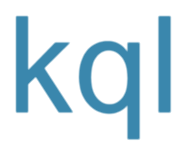

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
## Create a QueryProvider object for running queries in our LogAnalytics workspace
qry_prov = QueryProvider(data_environment='LogAnalytics')
## Use a workspace configuration with the name in msticpyconfig.yaml (you can also choose another workspace here)
ws_config = WorkspaceConfig(workspace="Default")
qry_prov.connect(connection_str=ws_config.code_connect_str)

# Parent Child Relationship Tree

With a collection of identifiers for processes and their parents, we can visualize the relationship through a directed graph which can be viewed to form a hierarchical graph. Focusing on a set of related processes can determine what actions, child processes, or network connections a singular process made in a given period.

## 1a. Query 

It should be noted that this query can be changed to any EventID as so long as the writer
can make the necessary changes in section 1c. In this case, we are focused on the parent-child relationship
between processes. The process in this case we are focused in on has the GUID of {8b54b755-561e-604f-c263-000000002a00}.
The query will pull every process who has the parent GUID of {8b54b755-561e-604f-c263-000000002a00} and return:
- Time 
- New child process path
- New child process command line
- New child process ID
- New child process GUID
- Parent process ID
- Parent process GUID

In [61]:
pid_query = '''
Sysmon
| where EventID == 1
| sort by TimeGenerated desc
| where InitiatingProcessGuid == "{8b54b755-561e-604f-c263-000000002a00}"
| project TimeGenerated, ProcessPath, ProcessCommandLine, ProcessId ,ProcessGuid, InitiatingProcessFile,InitiatingProcessGuid
'''
ProcessSearch = qry_prov.exec_query(query = pid_query)


<IPython.core.display.Javascript object>

## 1b. Results

As we can see, there are several different child processes spawned by {8b54b755-561e-604f-c263-000000002a00}, and we need to get a better grasp as to what is going on.

In [62]:
ProcessSearch

,TimeGenerated,ProcessPath,ProcessCommandLine,ProcessId,ProcessGuid,InitiatingProcessFile,InitiatingProcessGuid
0,2021-03-15 13:08:47.130000+00:00,C:\Windows\System32\cmd.exe,C:\WINDOWS\system32\cmd.exe /C psexec.exe -acc...,10376,{8b54b755-5c5f-604f-7164-000000002a00},C:\Windows\SysWOW64\rundll32.exe,{8b54b755-561e-604f-c263-000000002a00}
1,2021-03-15 13:08:44.443000+00:00,C:\Windows\System32\cmd.exe,C:\WINDOWS\system32\cmd.exe /C copy 19560.dll ...,4636,{8b54b755-5c5c-604f-6f64-000000002a00},C:\Windows\SysWOW64\rundll32.exe,{8b54b755-561e-604f-c263-000000002a00}
2,2021-03-15 13:06:58.260000+00:00,C:\Windows\System32\cmd.exe,"C:\WINDOWS\system32\cmd.exe /C net group ""Doma...",5320,{8b54b755-5bf2-604f-5d64-000000002a00},C:\Windows\SysWOW64\rundll32.exe,{8b54b755-561e-604f-c263-000000002a00}
3,2021-03-15 13:05:26.180000+00:00,C:\Windows\System32\cmd.exe,C:\WINDOWS\system32\cmd.exe /C nltest /dclist:,13896,{8b54b755-5b96-604f-4064-000000002a00},C:\Windows\SysWOW64\rundll32.exe,{8b54b755-561e-604f-c263-000000002a00}
4,2021-03-15 13:05:05.317000+00:00,C:\Windows\System32\cmd.exe,C:\WINDOWS\system32\cmd.exe /C c:\windows\sysn...,7180,{8b54b755-5b81-604f-3c64-000000002a00},C:\Windows\SysWOW64\rundll32.exe,{8b54b755-561e-604f-c263-000000002a00}
5,2021-03-15 13:04:23.320000+00:00,C:\Windows\SysWOW64\cmd.exe,C:\WINDOWS\system32\cmd.exe /C whoami,13840,{8b54b755-5b57-604f-3864-000000002a00},C:\Windows\SysWOW64\rundll32.exe,{8b54b755-561e-604f-c263-000000002a00}
6,2021-03-15 12:58:12.520000+00:00,C:\Windows\SysWOW64\cmd.exe,C:\WINDOWS\system32\cmd.exe /C c:\windows\sysn...,10924,{8b54b755-59e4-604f-1d64-000000002a00},C:\Windows\SysWOW64\rundll32.exe,{8b54b755-561e-604f-c263-000000002a00}
7,2021-03-15 12:55:49.230000+00:00,C:\Windows\SysWOW64\cmd.exe,C:\WINDOWS\system32\cmd.exe /C nltest /domain_...,8596,{8b54b755-5955-604f-1064-000000002a00},C:\Windows\SysWOW64\rundll32.exe,{8b54b755-561e-604f-c263-000000002a00}
8,2021-03-15 12:50:20.080000+00:00,C:\Windows\SysWOW64\cmd.exe,"C:\WINDOWS\system32\cmd.exe /C net group ""Ente...",7076,{8b54b755-580c-604f-f963-000000002a00},C:\Windows\SysWOW64\rundll32.exe,{8b54b755-561e-604f-c263-000000002a00}
9,2021-03-15 12:50:19.637000+00:00,C:\Windows\SysWOW64\cmd.exe,"C:\WINDOWS\system32\cmd.exe /C net group ""Doma...",7368,{8b54b755-580b-604f-f563-000000002a00},C:\Windows\SysWOW64\rundll32.exe,{8b54b755-561e-604f-c263-000000002a00}


# 2. Visualization with Networkx and Matplotlib

## 2a. Compile the results into a single dictionary


In [65]:
ParentChildRelationship = []
ParentBuffer = []
ChildBuffer = []
Child = ProcessSearch["ProcessId"].tolist() # Convert from a Pandas series to a list
Parent = ProcessSearch["InitiatingProcessGuid"].tolist()
RelationshipBuffer = dict(zip(
    Child,Parent
    ))

## 2b. Create a list of parent processes


In [66]:
for ParentGUID in RelationshipBuffer.values(): # Children are the keys and parents are the values for the Python dictionary
    if ParentGUID not in ParentBuffer: # If a parent is not in the parent buffer, add them
        ParentBuffer.append(ParentGUID)

## 2c. Enumerate ParentBuffer to create a new relationship list built of tuples 
> Creating a list of tuples ensures that NetworkX can read each of the parents and children as nodes and the process creation and edges

In [67]:
for Position,ParentProcessValue in enumerate(ParentBuffer):
    for Key,DictValue in RelationshipBuffer.items():
        if ParentProcessValue == DictValue:
            ParentChildRelationship.append((ParentProcessValue,Key))

# 2d. Visualizng the Graph with NetworkX and Malplotlib

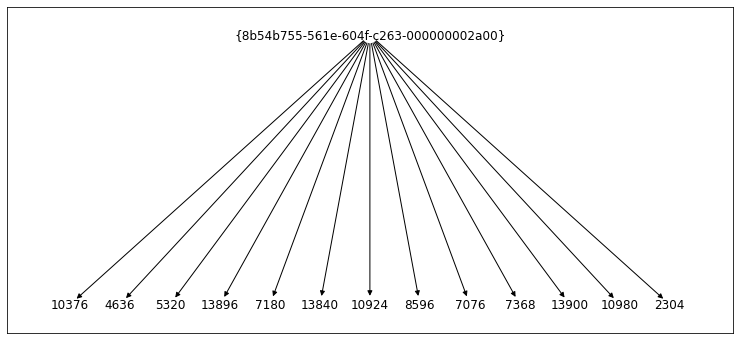

In [68]:
G=nx.DiGraph()
G.add_edges_from(ParentChildRelationship)
pos = hierarchy_pos(G)
plt.figure(figsize=(13, 6)) 
nx.draw_networkx_nodes(G, pos, node_shape="None")
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos)
plt.show()

# 3. Visualization with command lines

## 3b. Compile the results into a single dictionary

In [70]:
ChildCommandLine = ProcessSearch["ProcessCommandLine"].tolist()
ChildProcID = ProcessSearch["ProcessId"].tolist()
Child_Info = [(ChildCommandLine[i], ChildProcID[i]) for i in range(0, len(Child))]
ParentGuid = ProcessSearch["InitiatingProcessGuid"].tolist()
RelationshipBuffer = dict(zip(
    Child_Info,ParentGuid
    ))

## 3c. Create a list of parent processes

In [71]:
ParentChildRelationshipDictionary = {}
ParentBuffer = []

for i in RelationshipBuffer.values():
    if i not in ParentBuffer:
        ParentBuffer.append(i)

for Position,ParentProcessValue in enumerate(ParentBuffer):
    ChildBuffer = []
    for Key,DictValue in RelationshipBuffer.items():
        if ParentProcessValue == DictValue:
            ChildBuffer.append(Key)
    ParentChildRelationshipDictionary.update({ParentProcessValue:ChildBuffer})


## 3d. Visualize command lines with TreeLib
```
Parent GUID
├── Child Proc ID
    └── Child Commandline
```

In [72]:
from treelib import Node, Tree
Tree = Tree()
RootNode=""
for Key,DictValue in RelationshipBuffer.items():
    RootNode = DictValue
Tree.create_node(str(RootNode),str(RootNode)) # No parent means its the root node and there is only one key
for index in ParentChildRelationshipDictionary.values():
    for ChildInfo in index:
        Tree.create_node(str(ChildInfo[1]),str(ChildInfo[1]), parent=RootNode)
        Tree.create_node(str(ChildInfo[0]),parent=str(ChildInfo[1]))
Tree.show()

{8b54b755-561e-604f-c263-000000002a00}
├── 10376
│   └── C:\WINDOWS\system32\cmd.exe /C psexec.exe -accepteula -d -s \\[redacted]-dc1 rundll32.exe c:\windows\19560.dll,StartW
├── 10924
│   └── C:\WINDOWS\system32\cmd.exe /C c:\windows\sysnative\nltest /domain_trusts
├── 10980
│   └── C:\WINDOWS\system32\cmd.exe /C nltest /dclist:
├── 13840
│   └── C:\WINDOWS\system32\cmd.exe /C whoami
├── 13896
│   └── C:\WINDOWS\system32\cmd.exe /C nltest /dclist:
├── 13900
│   └── C:\WINDOWS\system32\cmd.exe /C nltest /domain_trusts
├── 2304
│   └── C:\WINDOWS\system32\cmd.exe /C gpupdate /force
├── 4636
│   └── C:\WINDOWS\system32\cmd.exe /C copy 19560.dll \\[redacted]-dc1\ADMIN$\ /Y /Z
├── 5320
│   └── C:\WINDOWS\system32\cmd.exe /C net group "Domain Admins" /dom
├── 7076
│   └── C:\WINDOWS\system32\cmd.exe /C net group "Enterprise admins" /domain
├── 7180
│   └── C:\WINDOWS\system32\cmd.exe /C c:\windows\sysnative\nltest /dclist:
├── 7368
│   └── C:\WINDOWS\system32\cmd.exe /C net group "Domain ad